### Random Forest

Dimensionality Reduction / Feature Selection

In [17]:
#import library
import os
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import cm
from sklearn.metrics import auc, roc_curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v3.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [4]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 28, 28)
y_train Shape: (109820,)
X_test Shape: (28688, 28, 28)
y_test Shape: (28688,)


In [5]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

In [ ]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

### Model Evalution

In [11]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

In [12]:
def plot_roc_curve(classifiers, X_train, y_train):
    n_classes = len(np.unique(y_train))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train == i, classifiers.predict_proba(X_train)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = cm.tab20(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [ ]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

In [ ]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [ ]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

#### Modeling with Random Forest

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grid Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [10, 20, 30]
}

In [ ]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, random_state=42, verbose=3)


In [ ]:
# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train_lda, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.483 total time= 2.1min
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.486 total time= 2.1min
[CV 3/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.488 total time= 2.0min
[CV 4/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.612 total time= 2.0min
[CV 5/5] END max_depth=10, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=0.904 total time= 2.0min
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.481 total time= 2.0min
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.482 total time= 2

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=3)

In [ ]:
#dumping randomized search cv into pickle file 
with open('/content/drive/Shareddrives/SignLanguageData/rfc_search.pkl','wb') as f:
  pickle.dump(rfc_search, f)

In [ ]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 30}


In [ ]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=200, min_samples_split=4, min_samples_leaf=2, 
                                   max_features=10, max_depth=30, random_state=42)

In [ ]:
# applying RFC on Training data
y_pred_rfc = rfc.fit(X_train_lda, y_train).predict(X_train_lda)

print(f"Accuracy: {accuracy_score(y_train, y_pred_rfc)}")
print("Classification report:")
print(classification_report(y_train, y_pred_rfc, target_names=letters))

Accuracy: 0.9987616099071207
Classification report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      4504
           B       1.00      1.00      1.00      4040
           C       1.00      1.00      1.00      4576
           D       1.00      1.00      1.00      4784
           E       1.00      1.00      1.00      3828
           F       1.00      1.00      1.00      4816
           G       1.00      1.00      1.00      4360
           H       1.00      1.00      1.00      4052
           I       1.00      1.00      1.00      4648
           K       1.00      1.00      1.00      4456
           L       1.00      1.00      1.00      4964
           M       1.00      1.00      1.00      4220
           N       1.00      1.00      1.00      4604
           O       1.00      1.00      1.00      4784
           P       1.00      1.00      1.00      4352
           Q       1.00      1.00      1.00      5116
           R       1.00      

In [ ]:
# dump RFC into pickle file
with open('/content/drive/Shareddrives/SignLanguageData/rfc_model_train.pkl', 'wb') as f:
    pickle.dump(y_pred_rfc, f)

In [ ]:
# applying RFC on Test data
y_pred_rfc_test = rfc.fit(X_train_lda, y_train).predict(X_test_lda)

In [ ]:
# dump RFC into pickle file
with open('/content/drive/Shareddrives/SignLanguageData/rfc_model_test.pkl', 'wb') as f:
    pickle.dump(y_pred_rfc_test, f)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_rfc_test)}")
print("Classification report:")
print(classification_report(y_test, y_pred_rfc_test, target_names=letters))

Accuracy: 0.5908393753485778
Classification report:
              precision    recall  f1-score   support

           A       0.57      0.74      0.65      1324
           B       0.79      0.66      0.72      1728
           C       0.83      0.77      0.80      1240
           D       0.52      0.58      0.55       980
           E       0.74      0.63      0.68      1992
           F       0.61      0.61      0.61       988
           G       0.72      0.62      0.67      1392
           H       0.86      0.70      0.77      1744
           I       0.52      0.61      0.56      1152
           K       0.52      0.50      0.51      1324
           L       0.58      0.82      0.68       836
           M       0.59      0.46      0.52      1576
           N       0.42      0.42      0.42      1164
           O       0.73      0.65      0.69       984
           P       0.89      0.75      0.81      1388
           Q       0.50      0.79      0.61       656
           R       0.18      

## Doing reandom search with new parameter

In [ ]:
n_estimators = np.arange(2,22,2)
max_depth = np.arange(2,22,2)
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [10, 20, 30]
}

In [ ]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, random_state=42, verbose=3)


In [ ]:
# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train_lda, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2;, score=0.355 total time=   6.7s
[CV 2/5] END max_depth=8, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2;, score=0.356 total time=   4.4s
[CV 3/5] END max_depth=8, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2;, score=0.357 total time=   3.0s
[CV 4/5] END max_depth=8, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2;, score=0.460 total time=   2.2s
[CV 5/5] END max_depth=8, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2;, score=0.740 total time=   2.1s
[CV 1/5] END max_depth=10, max_features=30, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.419 total time=  44.0s
[CV 2/5] END max_depth=10, max_features=30, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, score=0.417 total time=  37.1s
[CV 3/5] EN

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'max_features': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   random_state=42, verbose=3)

In [ ]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 18}


In [ ]:
n_estimators = np.arange(2,22,2)
max_depth = np.arange(2,22,2)
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [5, 10, 15]
}

In [ ]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, random_state=42, verbose=3)


In [ ]:
# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train_lda, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.322 total time=   1.1s
[CV 2/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.338 total time=   1.5s
[CV 3/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.336 total time=   1.5s
[CV 4/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.440 total time=   1.4s
[CV 5/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.720 total time=   1.4s
[CV 1/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.446 total time=  18.8s
[CV 2/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.444 total time=  19.0s
[C

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'max_features': [5, 10, 15],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   random_state=42, verbose=3)

In [ ]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 5, 'max_depth': 18}


In [ ]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                                   max_features=5, max_depth=18, random_state=42)

In [ ]:
# applying RFC on Training data
y_pred_rfc_train = rfc.fit(X_train_lda, y_train).predict(X_train_lda)

Accuracy: 0.8838371881260244
Classification report:
              precision    recall  f1-score   support

           A       0.87      0.91      0.89      4504
           B       0.91      0.91      0.91      4040
           C       0.96      0.94      0.95      4576
           D       0.87      0.83      0.85      4784
           E       0.90      0.89      0.90      3828
           F       0.92      0.88      0.90      4816
           G       0.94      0.93      0.94      4360
           H       0.95      0.92      0.94      4052
           I       0.82      0.88      0.85      4648
           K       0.86      0.84      0.85      4456
           L       0.86      0.90      0.88      4964
           M       0.88      0.83      0.85      4220
           N       0.88      0.85      0.87      4604
           O       0.93      0.94      0.94      4784
           P       0.95      0.95      0.95      4352
           Q       0.91      0.95      0.93      5116
           R       0.77      

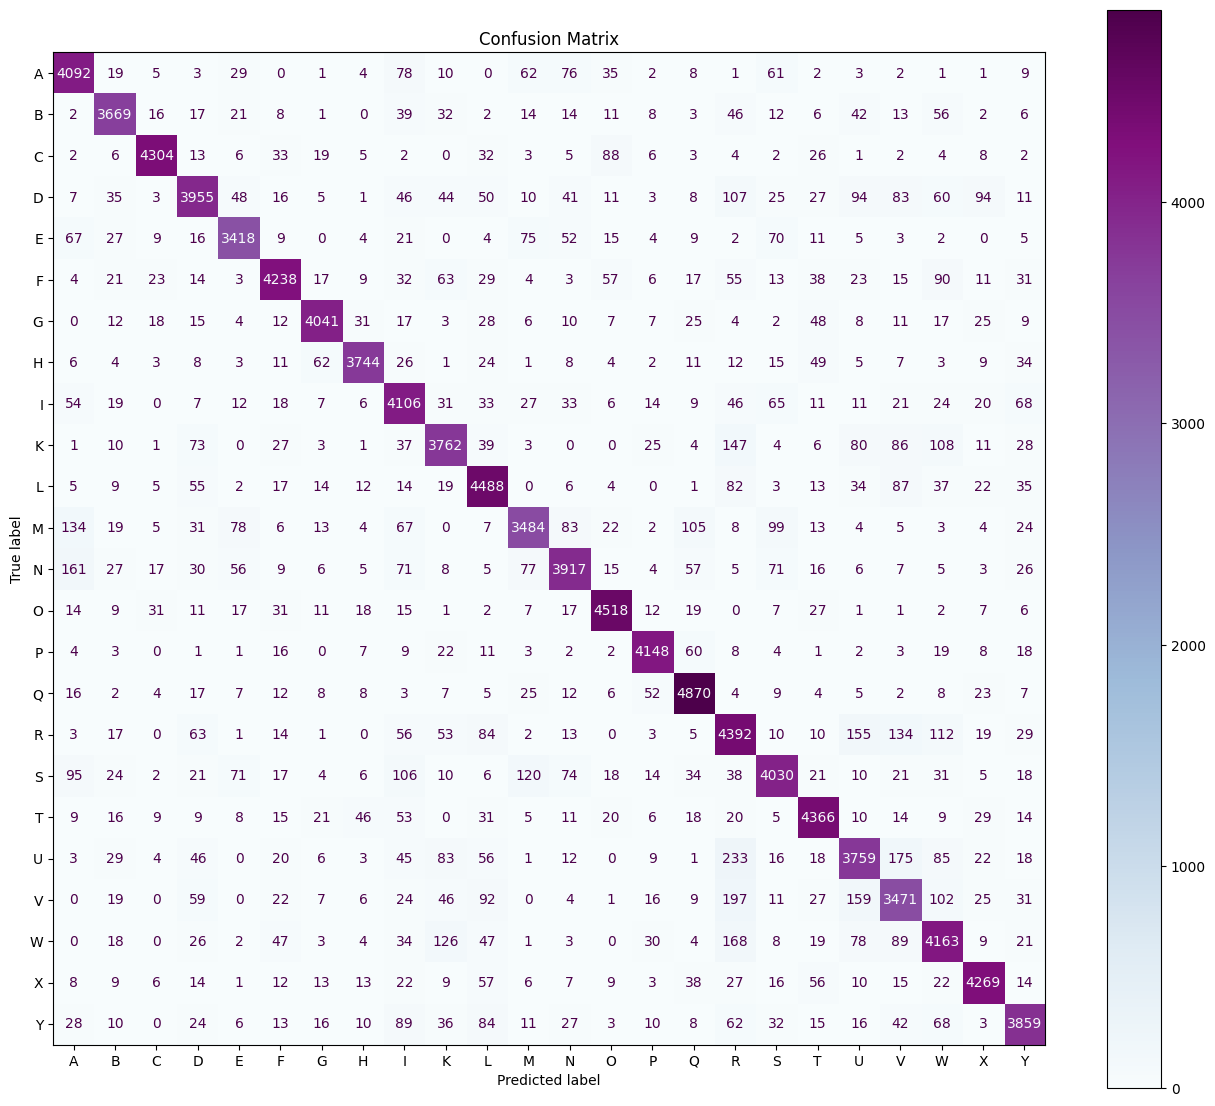

In [ ]:
evaluate_model(y_train, y_pred_rfc_train, letters)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


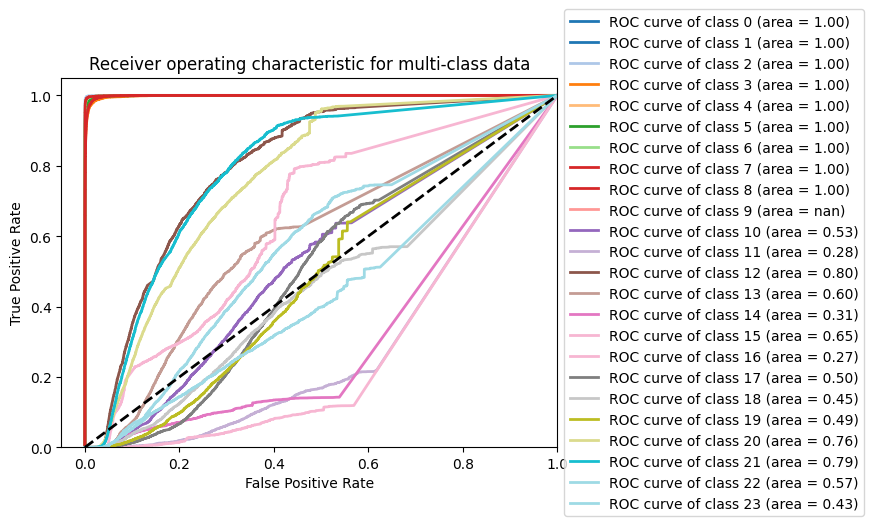

In [ ]:
from matplotlib import cm

n_classes = len(np.unique(y_train))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train == i, rfc.predict_proba(X_train_lda)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cm.tab20(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# applying RFC on Test data
y_pred_rfc_test = rfc.fit(X_train_lda, y_train).predict(X_test_lda)

Accuracy: 0.5475808700501952
Classification report:
              precision    recall  f1-score   support

           A       0.55      0.72      0.62      1324
           B       0.74      0.59      0.66      1728
           C       0.81      0.74      0.77      1240
           D       0.47      0.51      0.49       980
           E       0.71      0.58      0.64      1992
           F       0.55      0.57      0.56       988
           G       0.67      0.59      0.63      1392
           H       0.82      0.65      0.72      1744
           I       0.47      0.55      0.51      1152
           K       0.48      0.46      0.47      1324
           L       0.56      0.81      0.66       836
           M       0.52      0.41      0.46      1576
           N       0.40      0.37      0.38      1164
           O       0.68      0.63      0.66       984
           P       0.84      0.73      0.78      1388
           Q       0.48      0.78      0.59       656
           R       0.14      

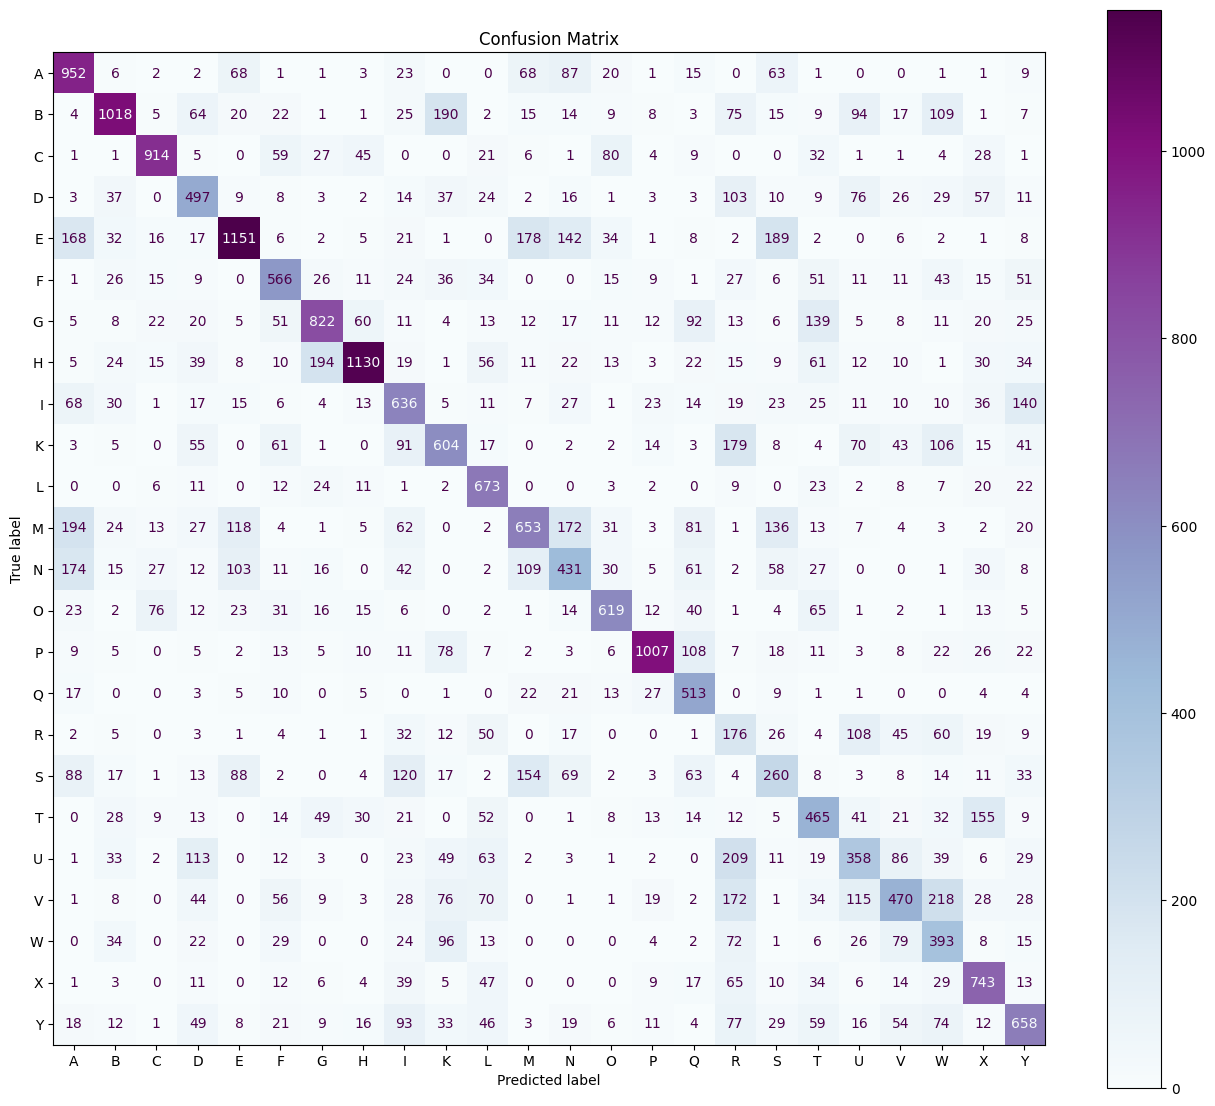

In [ ]:
evaluate_model(y_test, y_pred_rfc_test, letters)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


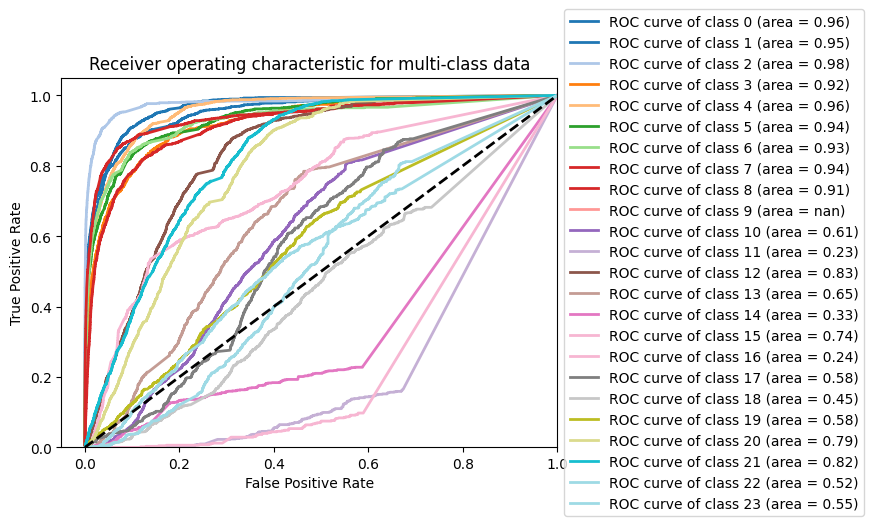

In [ ]:
from matplotlib import cm

n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, rfc.predict_proba(X_test_lda)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cm.tab20(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=8, min_samples_split=10, min_samples_leaf=5, 
                                   max_features=5, max_depth=8, random_state=42)

In [ ]:
# applying RFC on Training data
y_pred_rfc_train = rfc.fit(X_train_lda, y_train).predict(X_train_lda)

Accuracy: 0.5503004917137133
Classification report:
              precision    recall  f1-score   support

           A       0.54      0.63      0.58      4504
           B       0.54      0.58      0.56      4040
           C       0.76      0.76      0.76      4576
           D       0.63      0.37      0.47      4784
           E       0.54      0.54      0.54      3828
           F       0.66      0.51      0.58      4816
           G       0.70      0.65      0.68      4360
           H       0.74      0.56      0.63      4052
           I       0.43      0.58      0.49      4648
           K       0.48      0.59      0.53      4456
           L       0.50      0.71      0.59      4964
           M       0.45      0.49      0.47      4220
           N       0.53      0.44      0.48      4604
           O       0.70      0.73      0.72      4784
           P       0.72      0.72      0.72      4352
           Q       0.67      0.76      0.71      5116
           R       0.35      

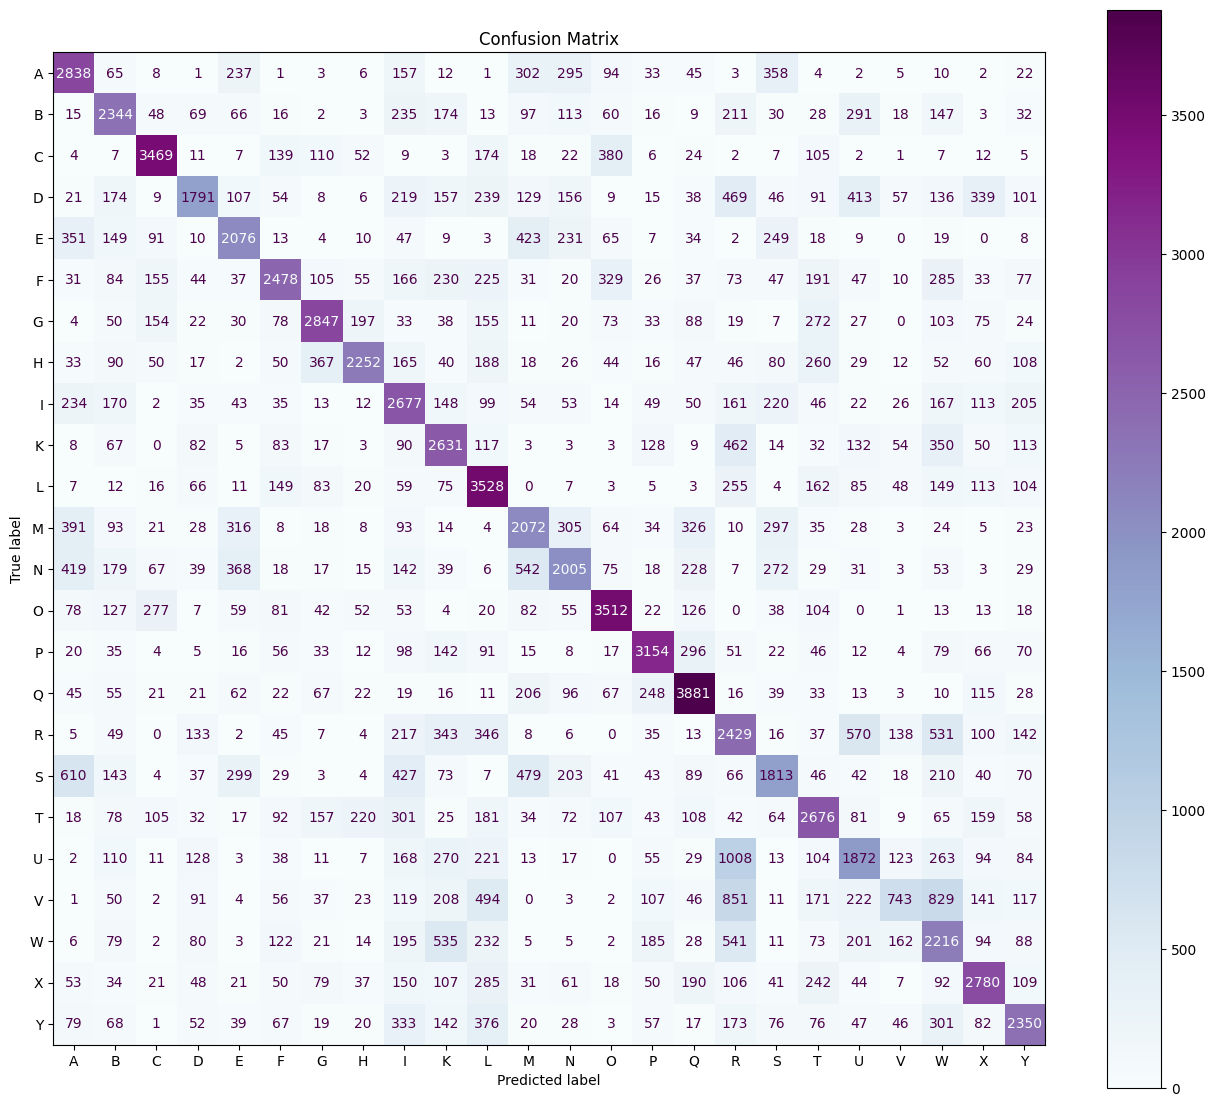

In [ ]:
evaluate_model(y_train, y_pred_rfc_train, letters)

In [ ]:
# applying RFC on Test data
y_pred_rfc_test = rfc.fit(X_train_lda, y_train).predict(X_test_lda)

Accuracy: 0.4000627440044618
Classification report:
              precision    recall  f1-score   support

           A       0.45      0.62      0.52      1324
           B       0.54      0.42      0.48      1728
           C       0.66      0.62      0.64      1240
           D       0.40      0.30      0.35       980
           E       0.60      0.42      0.49      1992
           F       0.43      0.37      0.40       988
           G       0.54      0.46      0.50      1392
           H       0.77      0.39      0.52      1744
           I       0.25      0.36      0.29      1152
           K       0.29      0.35      0.32      1324
           L       0.38      0.77      0.51       836
           M       0.39      0.38      0.38      1576
           N       0.30      0.24      0.27      1164
           O       0.53      0.56      0.54       984
           P       0.74      0.63      0.68      1388
           Q       0.34      0.63      0.44       656
           R       0.05      

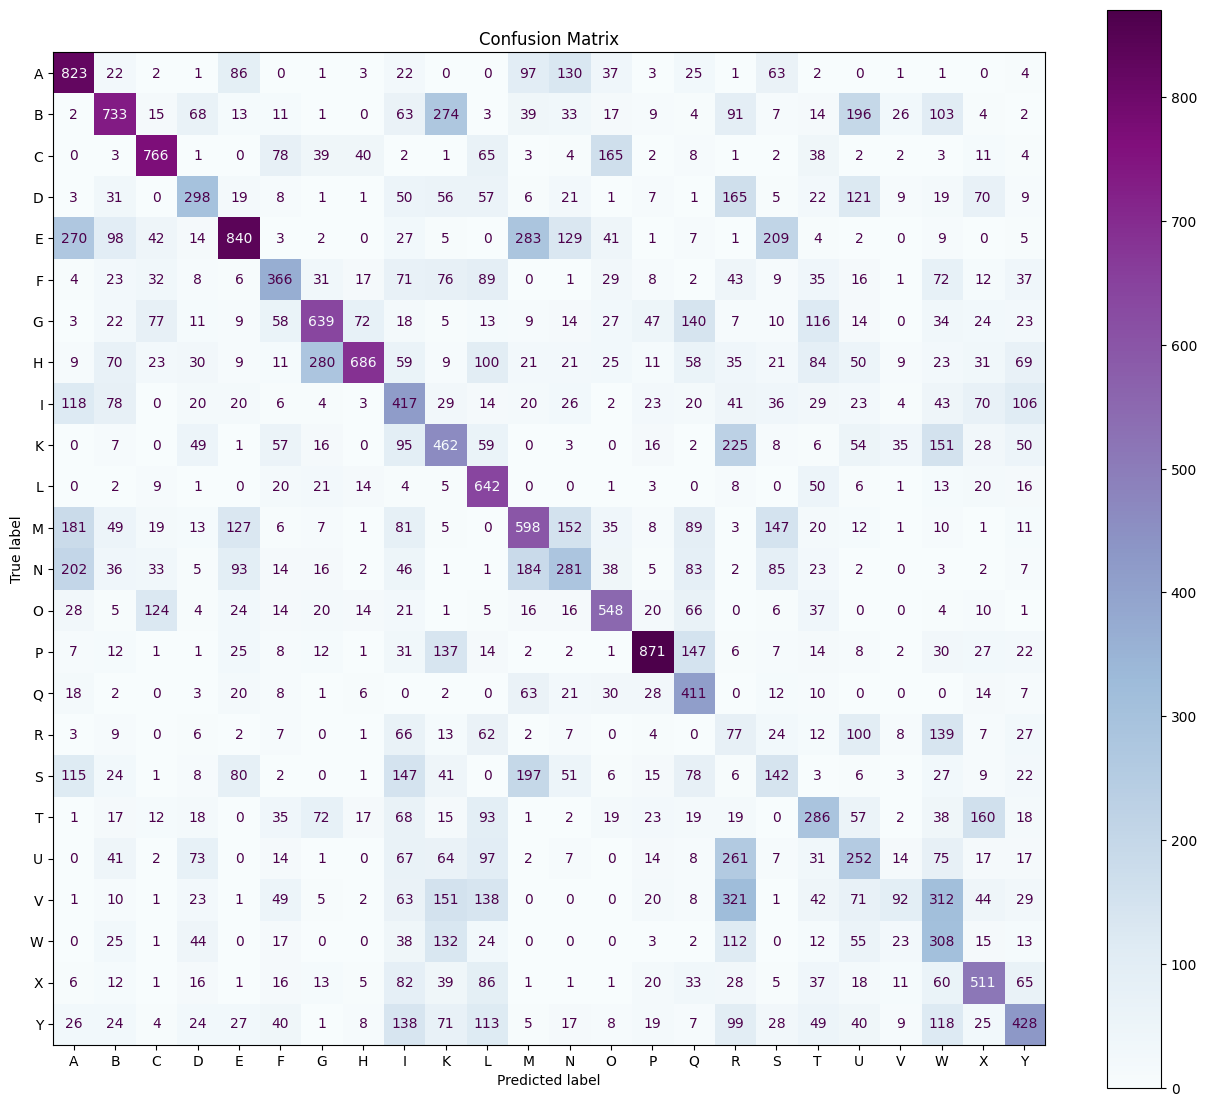

In [ ]:
evaluate_model(y_test, y_pred_rfc_test, letters)

In [ ]:
# Load the combined data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [ ]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 423)
y_train Shape: (109820,)
X_test Shape: (28688, 423)
y_test Shape: (28688,)


In [ ]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=8, min_samples_split=10, min_samples_leaf=5, 
                                   max_features=5, max_depth=8, random_state=42)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=8, random_state=42)

In [ ]:
# applying RFC on Training data
y_pred_rfc_train = rfc.predict(X_train)

Accuracy: 0.459533782553269
Classification report:
              precision    recall  f1-score   support

           A       0.47      0.52      0.49      4504
           B       0.55      0.25      0.35      4040
           C       0.62      0.71      0.66      4576
           D       0.49      0.27      0.35      4784
           E       0.56      0.30      0.39      3828
           F       0.53      0.52      0.52      4816
           G       0.57      0.62      0.60      4360
           H       0.60      0.50      0.54      4052
           I       0.39      0.45      0.42      4648
           K       0.41      0.55      0.47      4456
           L       0.42      0.62      0.50      4964
           M       0.50      0.17      0.25      4220
           N       0.42      0.23      0.30      4604
           O       0.56      0.69      0.62      4784
           P       0.60      0.80      0.68      4352
           Q       0.59      0.84      0.70      5116
           R       0.21      0

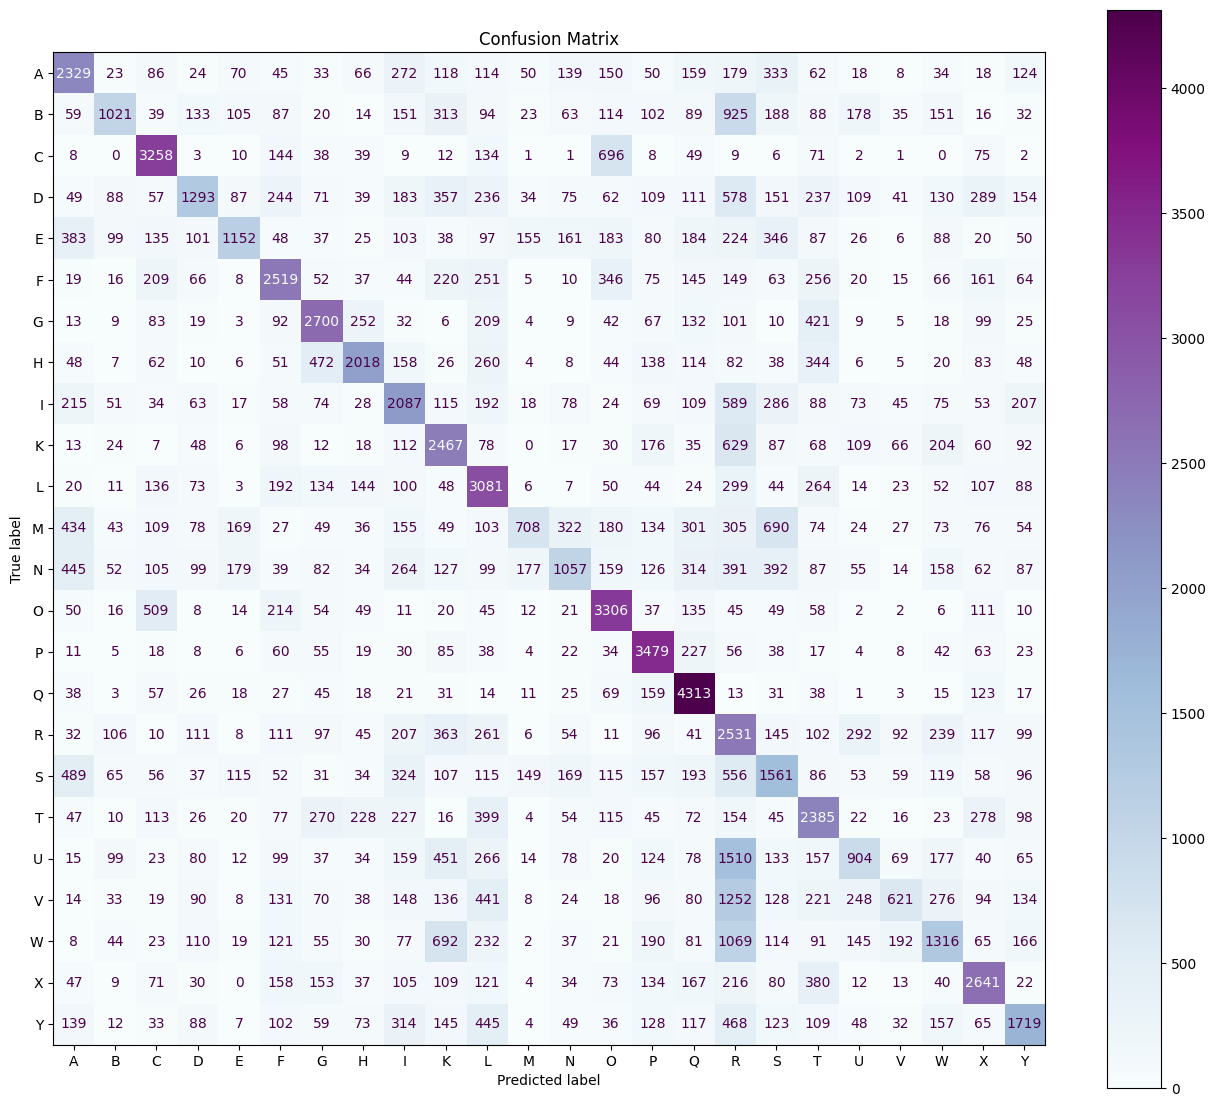

In [ ]:
evaluate_model(y_train, y_pred_rfc_train, letters)

In [ ]:
# applying RFC on Test data
y_pred_rfc_test = rfc.predict(X_test)

Accuracy: 0.05371583937534858
Classification report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00      1324
           B       0.59      0.01      0.02      1728
           C       0.36      0.16      0.23      1240
           D       0.00      0.00      0.00       980
           E       0.00      0.00      0.00      1992
           F       0.20      0.00      0.00       988
           G       0.00      0.00      0.00      1392
           H       0.12      0.05      0.07      1744
           I       0.00      0.00      0.00      1152
           K       0.00      0.00      0.00      1324
           L       0.13      0.00      0.00       836
           M       0.00      0.00      0.00      1576
           N       0.00      0.00      0.00      1164
           O       0.02      0.42      0.04       984
           P       0.22      0.44      0.29      1388
           Q       0.03      0.32      0.06       656
           R       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cohen's Kappa: 0.020368810091431433


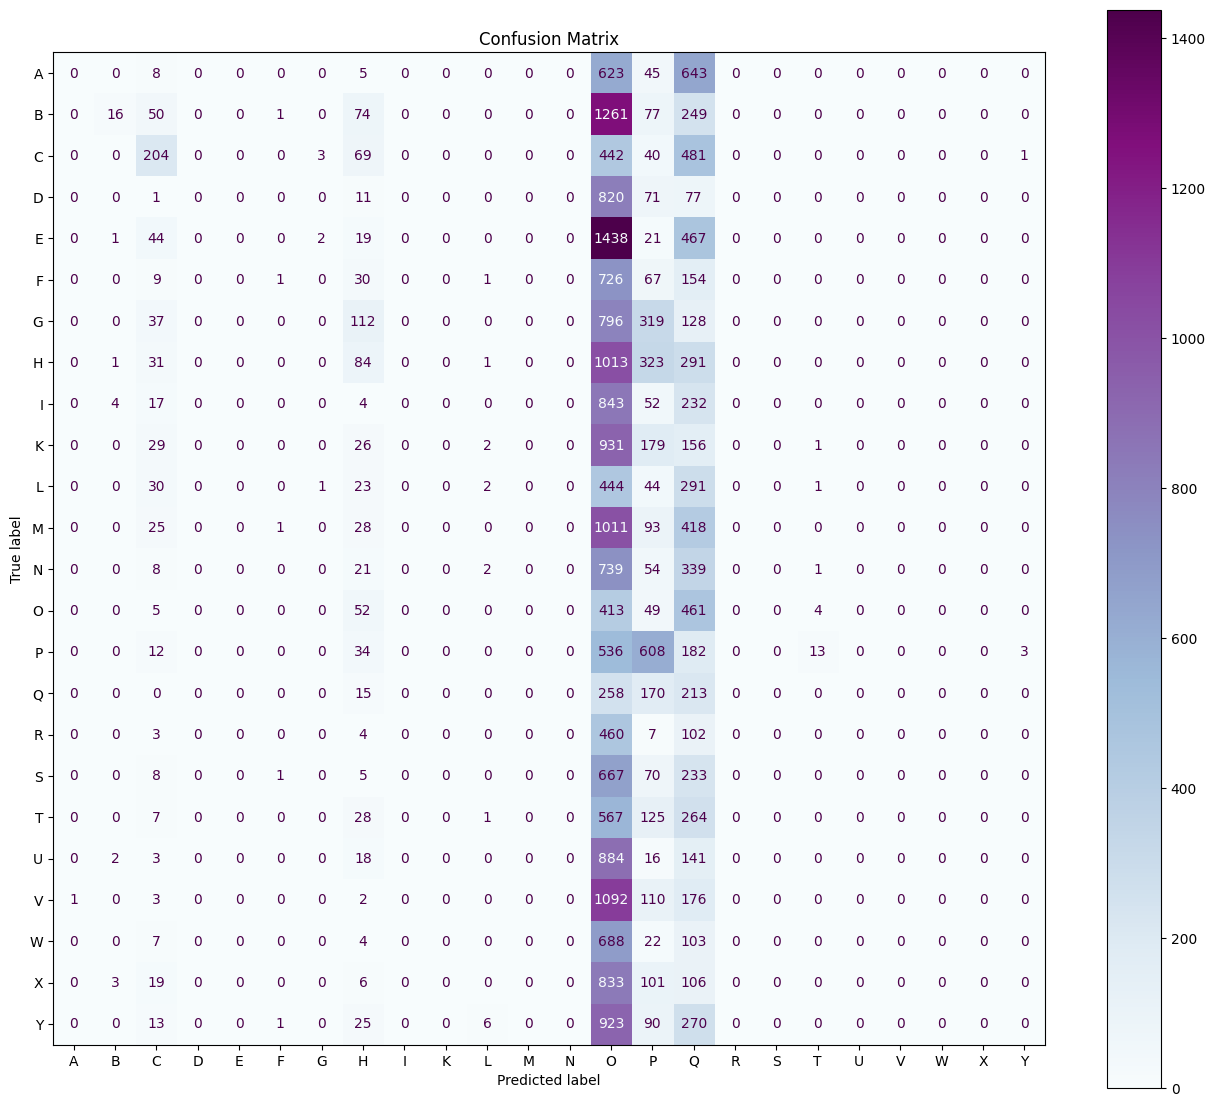

In [ ]:
evaluate_model(y_test, y_pred_rfc_test, letters)

### Loading new features LDA+HOG PCA

In [6]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [7]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [8]:
n_estimators = np.arange(2,22,2)
max_depth = np.arange(2,22,2)
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [5, 10, 15]
}

In [6]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc,
                                param_distributions = param_grid,
                                cv = 5, 
                                random_state=42,
                                verbose=3)

In [7]:
# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.450 total time=   3.1s
[CV 2/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.445 total time=   2.6s
[CV 3/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.435 total time=   5.0s
[CV 4/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.432 total time=   2.5s
[CV 5/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.458 total time=   2.8s
[CV 1/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.701 total time=  28.9s
[CV 2/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.694 total time=  19.5s
[C

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'max_features': [5, 10, 15],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   random_state=42, verbose=3)

In [8]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 5, 'max_depth': 18}


In [9]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                                   max_features=5, max_depth=5, random_state=42)

In [10]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=20, random_state=42)

In [33]:
import pickle

# Define the path where you want to save your pickled model
path = "/content/drive/Shareddrives/SignLanguageData/rfc_model.pkl"

# Pickle the model and save it to the specified path
with open(path, "wb") as file:
    pickle.dump(rfc, file)


In [15]:
# applying Logistic regression and predicting on train
y_pred_train = rfc.predict(X_train)
# testing logistic regression on test data
y_pred_test = rfc.predict(X_test)


Accuracy: 0.5359315243125113
Classification report:
              precision    recall  f1-score   support

           A       0.47      0.77      0.58      4504
           B       0.72      0.48      0.57      4040
           C       0.74      0.77      0.75      4576
           D       0.57      0.43      0.49      4784
           E       0.61      0.45      0.52      3828
           F       0.64      0.57      0.60      4816
           G       0.68      0.67      0.67      4360
           H       0.70      0.52      0.60      4052
           I       0.50      0.56      0.53      4648
           K       0.54      0.39      0.45      4456
           L       0.45      0.74      0.56      4964
           M       0.50      0.36      0.42      4220
           N       0.53      0.35      0.42      4604
           O       0.64      0.70      0.67      4784
           P       0.69      0.78      0.73      4352
           Q       0.61      0.85      0.71      5116
           R       0.27      

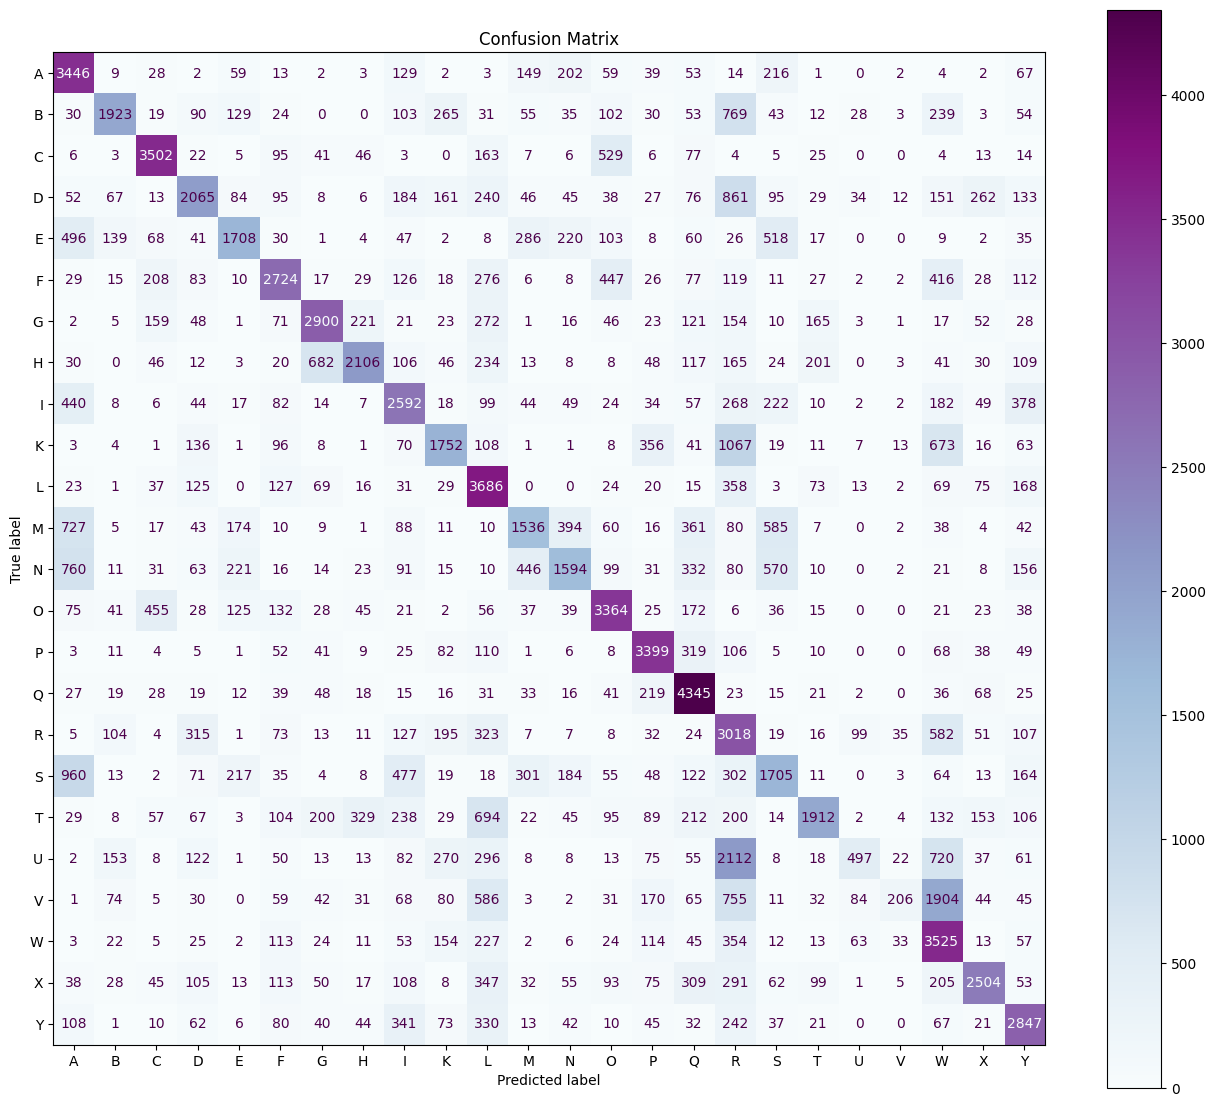

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


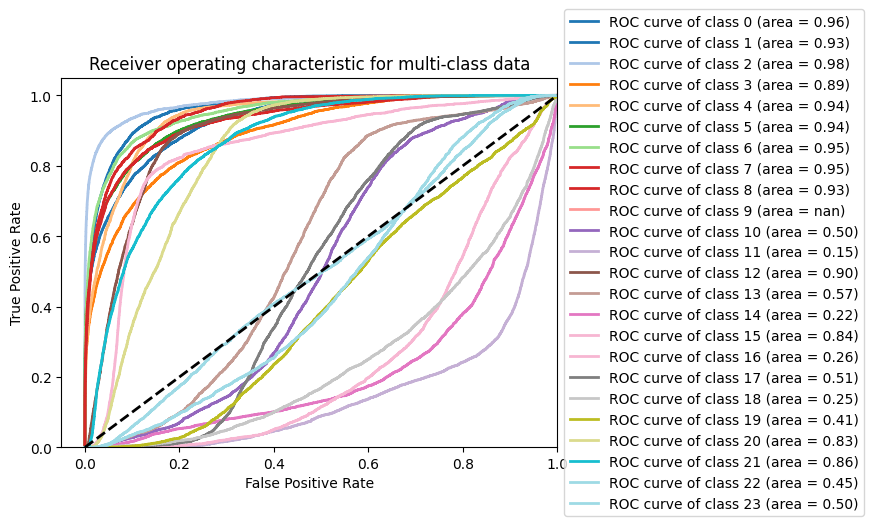

In [18]:
evaluate_model(y_train, y_pred_train, letters)
plot_roc_curve(rfc, X_train, y_train)

Accuracy: 0.4216745677635248
Classification report:
              precision    recall  f1-score   support

           A       0.41      0.78      0.54      1324
           B       0.77      0.34      0.48      1728
           C       0.72      0.62      0.66      1240
           D       0.40      0.33      0.36       980
           E       0.70      0.38      0.49      1992
           F       0.48      0.47      0.48       988
           G       0.56      0.50      0.53      1392
           H       0.81      0.42      0.55      1744
           I       0.36      0.39      0.37      1152
           K       0.33      0.23      0.27      1324
           L       0.34      0.83      0.48       836
           M       0.44      0.25      0.32      1576
           N       0.32      0.23      0.27      1164
           O       0.48      0.60      0.53       984
           P       0.77      0.76      0.76      1388
           Q       0.33      0.77      0.46       656
           R       0.12      

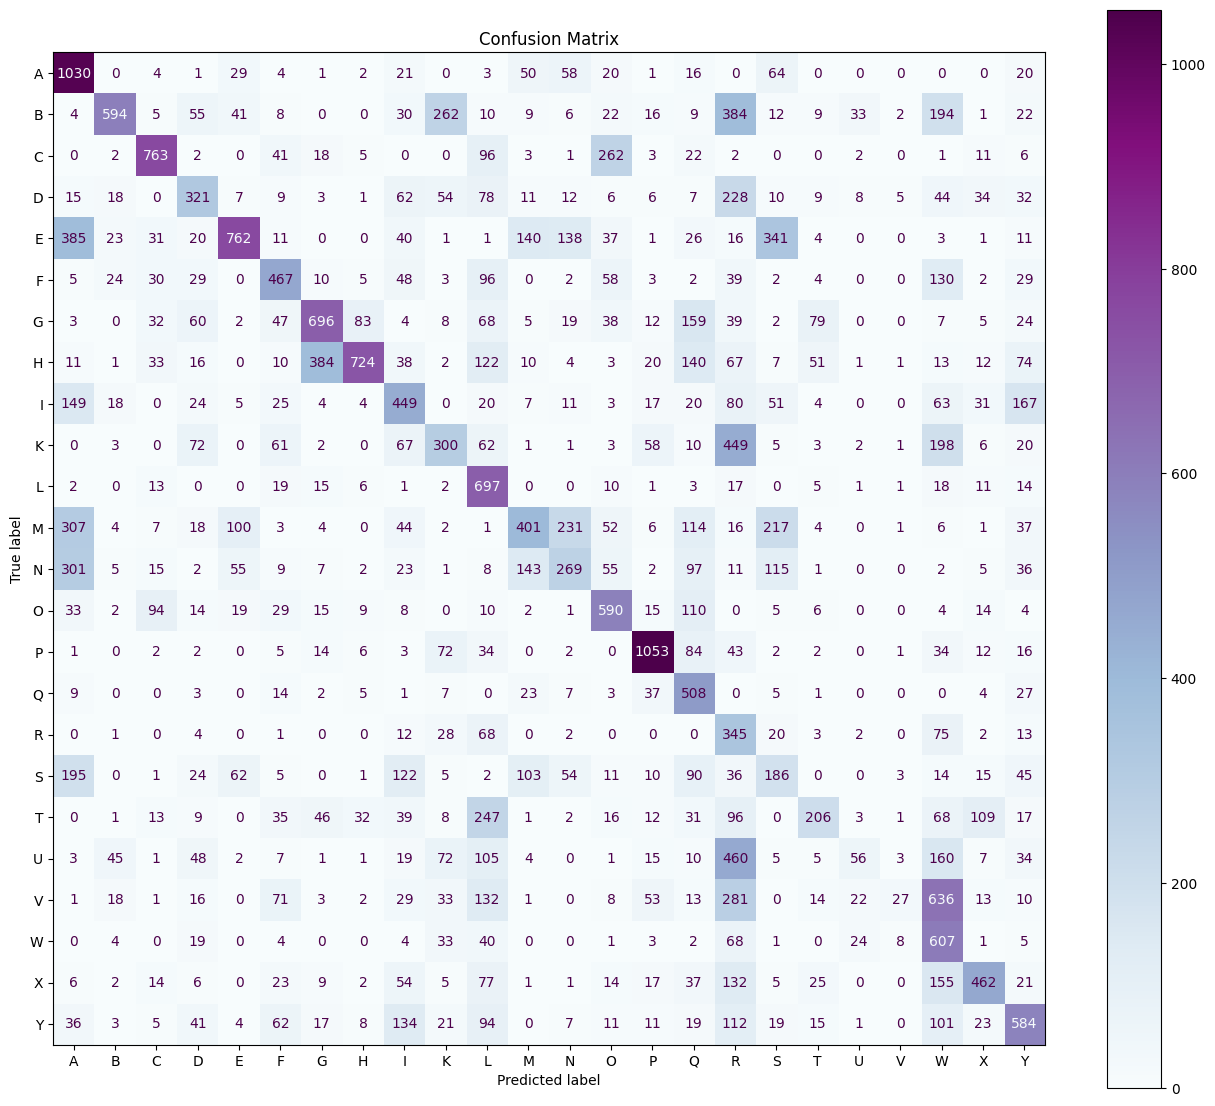

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


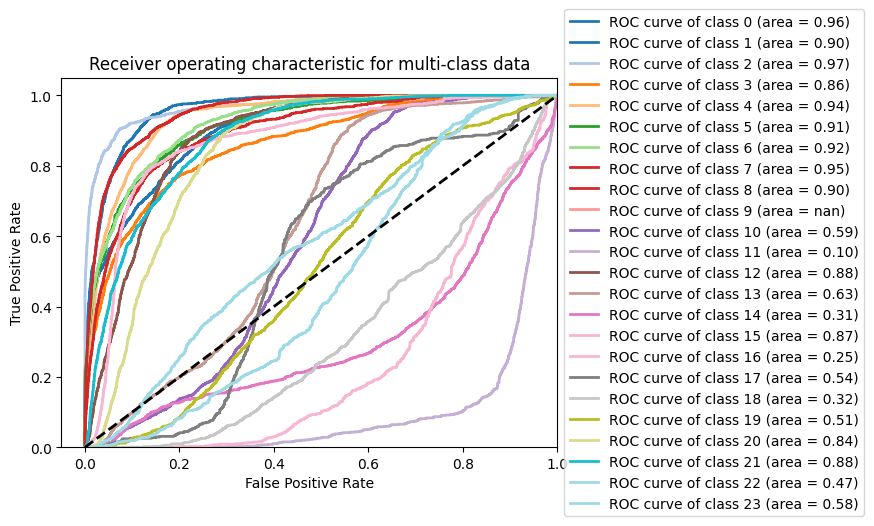

In [20]:
evaluate_model(y_test, y_pred_test, letters)
plot_roc_curve(rfc, X_test, y_test)